# OSM Contributions by Country

For the time period of the survey (January - February 2021), where have contributors been editing OSM, in relation to where they may live (by Country).

### How do we determine which Country a mapper might be from?
There has been a decent amount of research on this question, and it's a moving target. One reasonable thought (if we ignore humanitarian or paid-editing teams), is that the Country in which a mapper makes the majority of their changesets is perhaps their home. If not their _actual home_, it is still clearly a location they posess knowledge of and continually map. Some of Pascal Neis's tools use this approach, so I will re-create it here roughly. 

Quick & Dirty: Group all of a users changesets from the last five years together based on the rounded value of the min lon/lat from the changeset metadata. If the corner of a changeset bounding box is (11.272132, 23.838870), it becomes (11,24). Make a list of these rounded coordinates and take the MODE (most commonly occuring). Now see which Country that point falls within.

<hr>

_Note, as of February 12, the most recent data available on the AWS public dataset is is 2/08/2021, so this is not the entire editing window of the survey. This approach should, however, continue to work as we get more changesets._

Thanks!

[Jennings Anderson](https://jenningsanderson.com)

In [1]:
import pandas as pd; import geopandas as gpd; import seaborn as sns
from shapely.geometry import Point;
import fiona, sys, json;
from matplotlib.ticker import FuncFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
0,1,American Samoa,AS,United States,US,0.600124,0.013720,"MULTIPOLYGON (((-170.68108 -14.45336, -170.915..."
1,2,United States Minor Outlying Islands,UM,United States,US,0.480216,0.003216,"MULTIPOLYGON (((166.75626 19.26052, 166.62574 ..."
2,3,Cook Islands,CK,New Zealand,NZ,0.980664,0.013073,"MULTIPOLYGON (((-157.64424 -19.92979, -157.824..."


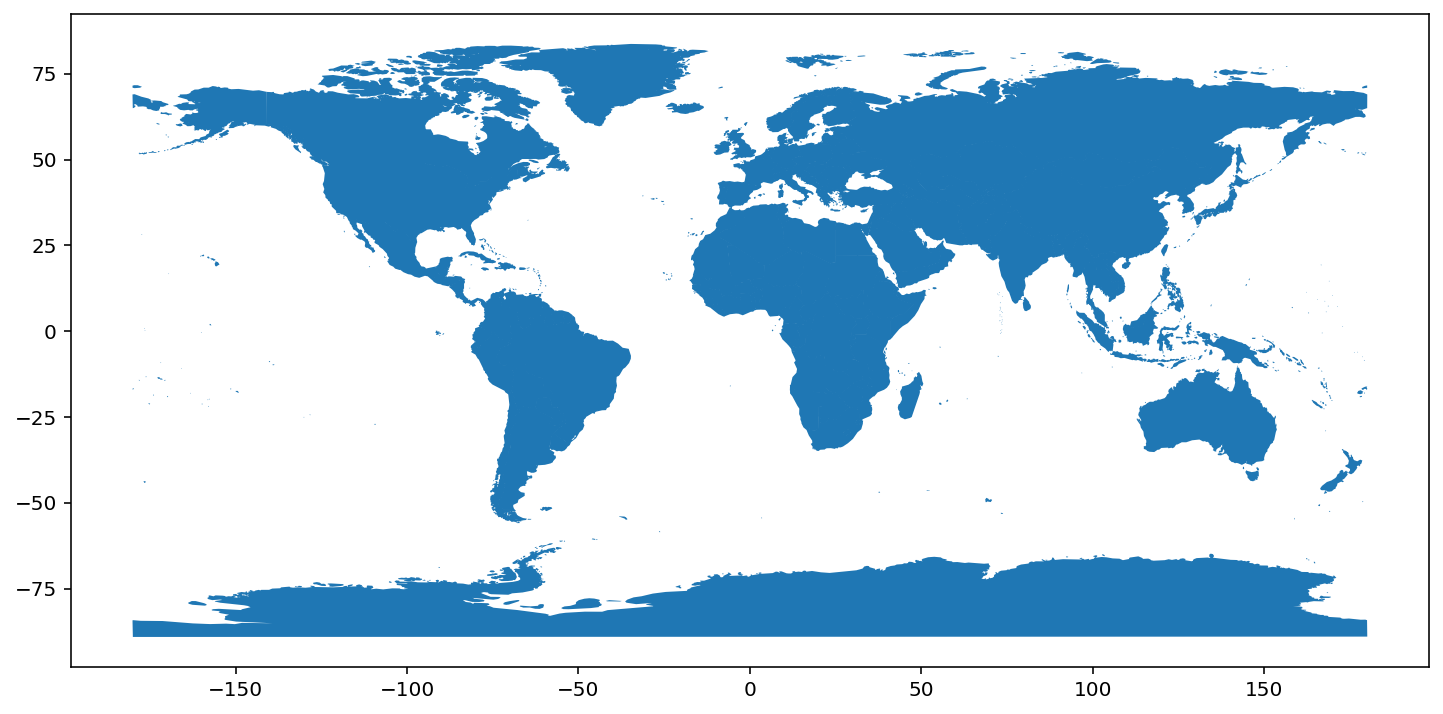

In [2]:
#First, read in a file that has Country Boundaries
countries = gpd.read_file('./data/country_outlines_simplified_2.geojson') #Simplified geometries; not exact.
countries.plot(figsize=(16,6))
countries.head(3)

In [3]:
countries[['COUNTRY','ISO','geometry']].to_csv('countries.tsv', header=False, sep='\t')

In [16]:
survey_regions = gpd.read_file('/Users/jenningsa/data/osmf-survey-regions.geojson')
survey_regions.head(1)

,OSMF Region,Responses,geometry
0,Philippines,Yes,"MULTIPOLYGON (((118.50458 9.31638, 117.17427 8..."


<AxesSubplot:>

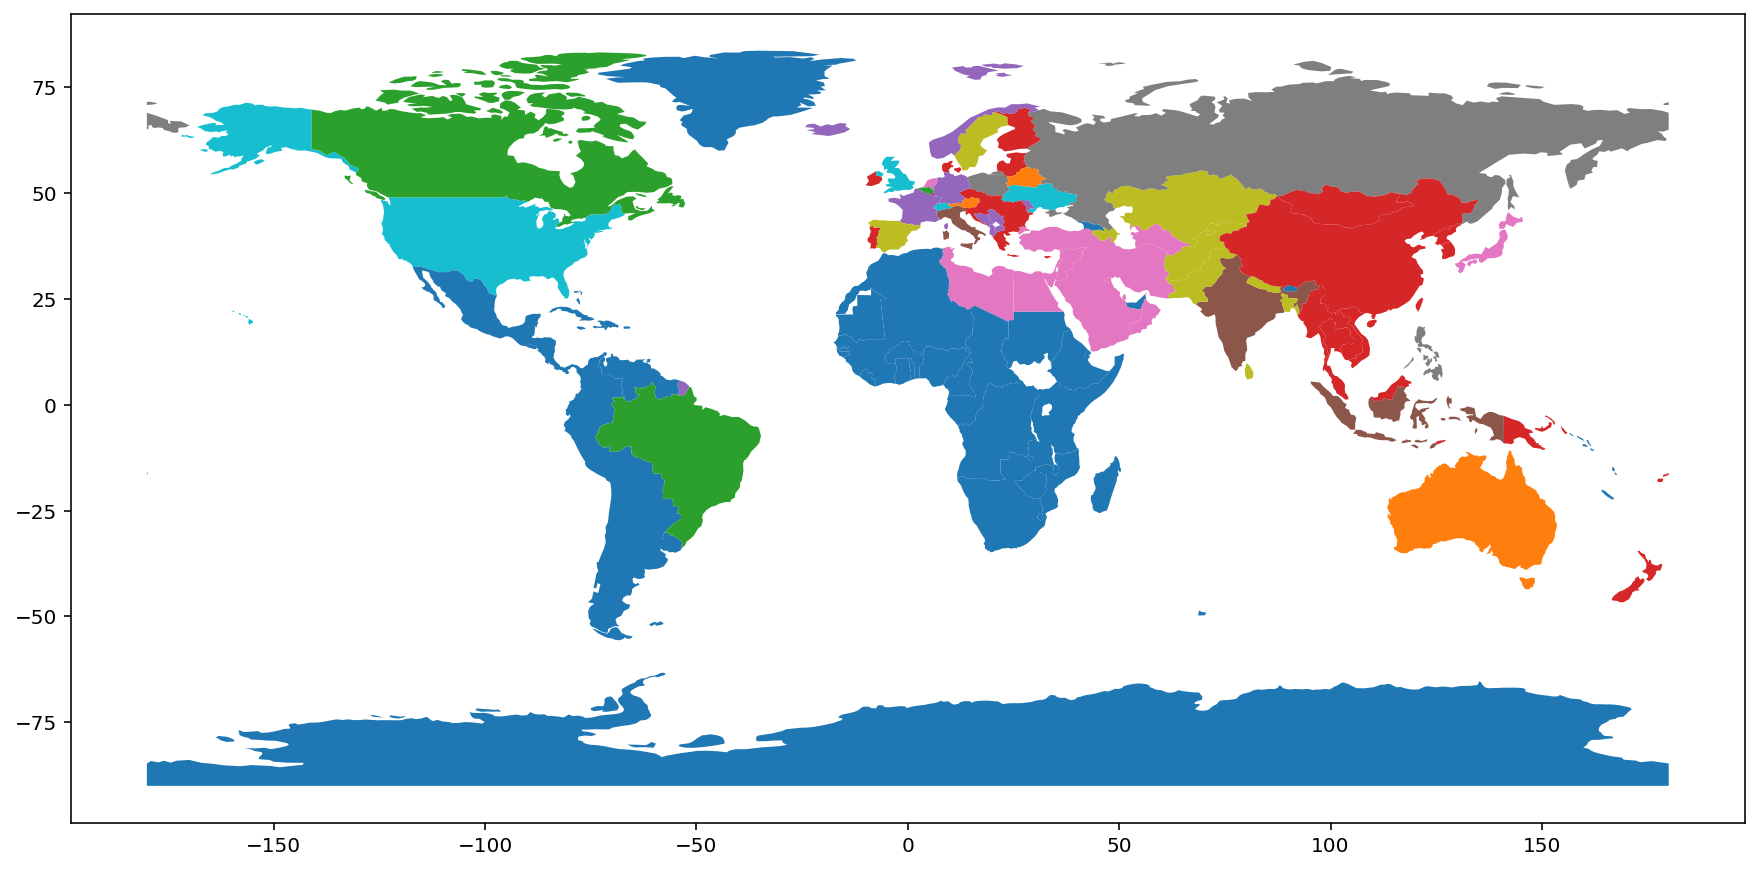

In [17]:
survey_regions.plot(column='OSMF Region', figsize=(15,8))

Use this file with AWS Athena to do spatial join on regions

In [44]:
survey_regions['region_combined'] = survey_regions['OSMF Region'] + "-" + survey_regions['Responses']
t = survey_regions.reset_index().rename(columns={'index':'code','region_combined':'country'})
t.code = t.code.apply(lambda i: "region_"+str(i))
t[['country','code','geometry']].to_csv('countries2.tsv', header=False, sep='\t')

<AxesSubplot:>

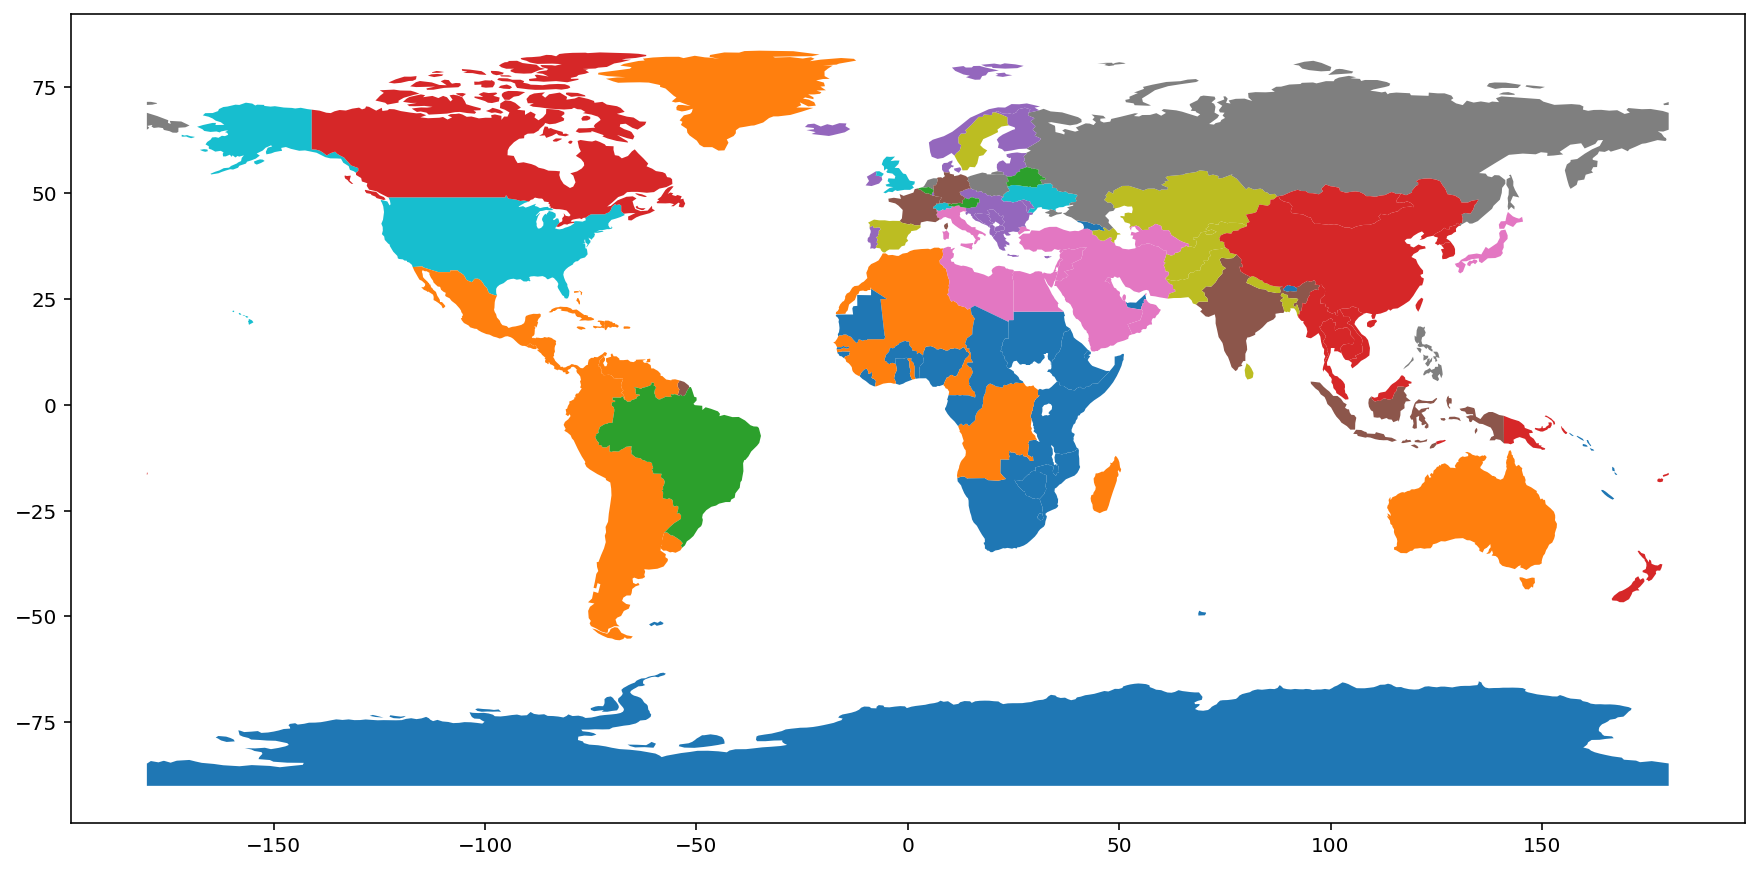

In [40]:
t.plot(column='country', figsize=(15,8))

# Query:

Extract our data from the OSM Changesets data on AWS:

_Get the new query_

Save this file as `OSM_changesets.csv`

In [78]:
#Now read in the changesets file from this query: 
changesets = pd.read_csv('~/data/2020_changesets_with_home_locations.csv')
changesets['geometry'] = changesets.apply(lambda row: Point(row.min_lon, row.min_lat), axis=1)
changesets = gpd.GeoDataFrame(changesets)
changesets['country'] = None

In [79]:
print("Read in {:,} changesets".format(len(changesets)))
print("First Changeset: https://openstreetmap.org/changeset/{}\nLatest Changeset: https://openstreetmap.org/changeset/{}".format(changesets.id.min(), changesets.id.max()))

Read in 19,798,974 changesets
First Changeset: https://openstreetmap.org/changeset/79071017
Latest Changeset: https://openstreetmap.org/changeset/98870277


In [80]:
# We want to find a "home country" for each user
homes = pd.DataFrame(changesets[['uid','frequent_editing_location']].drop_duplicates('uid', keep='first'))
homes.frequent_editing_location = homes.frequent_editing_location.apply(lambda c: 
                                                                        ( json.loads(c)[0], json.loads(c)[1]))
# There are a handful of mappers that error out here, not sure why? (maybe 70?)
homes['geometry'] = homes.frequent_editing_location.apply(lambda t: Point(t) if t[0]!=None else None)
homes = gpd.GeoDataFrame(homes[~pd.isna(homes.geometry)]).set_crs(epsg=4326)
print("Found {:,} mappers".format(len(homes)))
homes.head(2)

Found 327,339 mappers


,uid,frequent_editing_location,geometry
0,4997045,"(18, 48)",POINT (18.00000 48.00000)
1,1255433,"(85, 56)",POINT (85.00000 56.00000)


In [81]:
#Iterate through all of the Countries and label changesets with a Country name
user_homes = []

# for idx, country in countries[countries.ISO=='FR'].iterrows(): #test for France?
for idx, country in countries.iterrows(): 
    users_from_here = homes[homes.geometry.within(country.geometry)]
    edits_in_here   = changesets[changesets.geometry.within(country.geometry)]

    if len(users_from_here):
        for uid in users_from_here.uid:
            user_homes.append({
                'uid':uid,
                'home_country':country.COUNTRY,
                'home_country_geom': country.geometry
            })
    
    if len(edits_in_here):
        changesets.loc[edits_in_here.index,'country'] = country.COUNTRY
        
    sys.stderr.write("\r{:,} countries processed    ".format(idx+1))

154 countries processed    

KeyboardInterrupt: 

In [ ]:
print("Overall, identified potential (likely?) home countries for {:,} mappers".format(len(user_homes)))

In [ ]:
df = changesets.merge(pd.DataFrame(user_homes), on='uid')
df['is_local'] = df.home_country == df.country
df.head(2)

In [ ]:
df.drop_duplicates(subset='uid')[
    ['uid','editing_days_in_last365','home_country','frequent_editing_location']
].to_csv('2020_user_homes.csv')

# Aggregate Per Country

Counts the number of Changesets submitted per Country — as in, the Country that the changeset falls within. In this case, "local" refers to whether or not the mapper who submitted each changeset is _likely_ from that Country.

Countries like the USA are going to be over-inflated with "local" changesets because of mapping teams like Amazon Logistics that almost exclusively edit in the US, and with huge volume. 

In [15]:
list(reversed(sns.color_palette(as_cmap=True)[:2]))

['#ff7f0e', '#1f77b4']

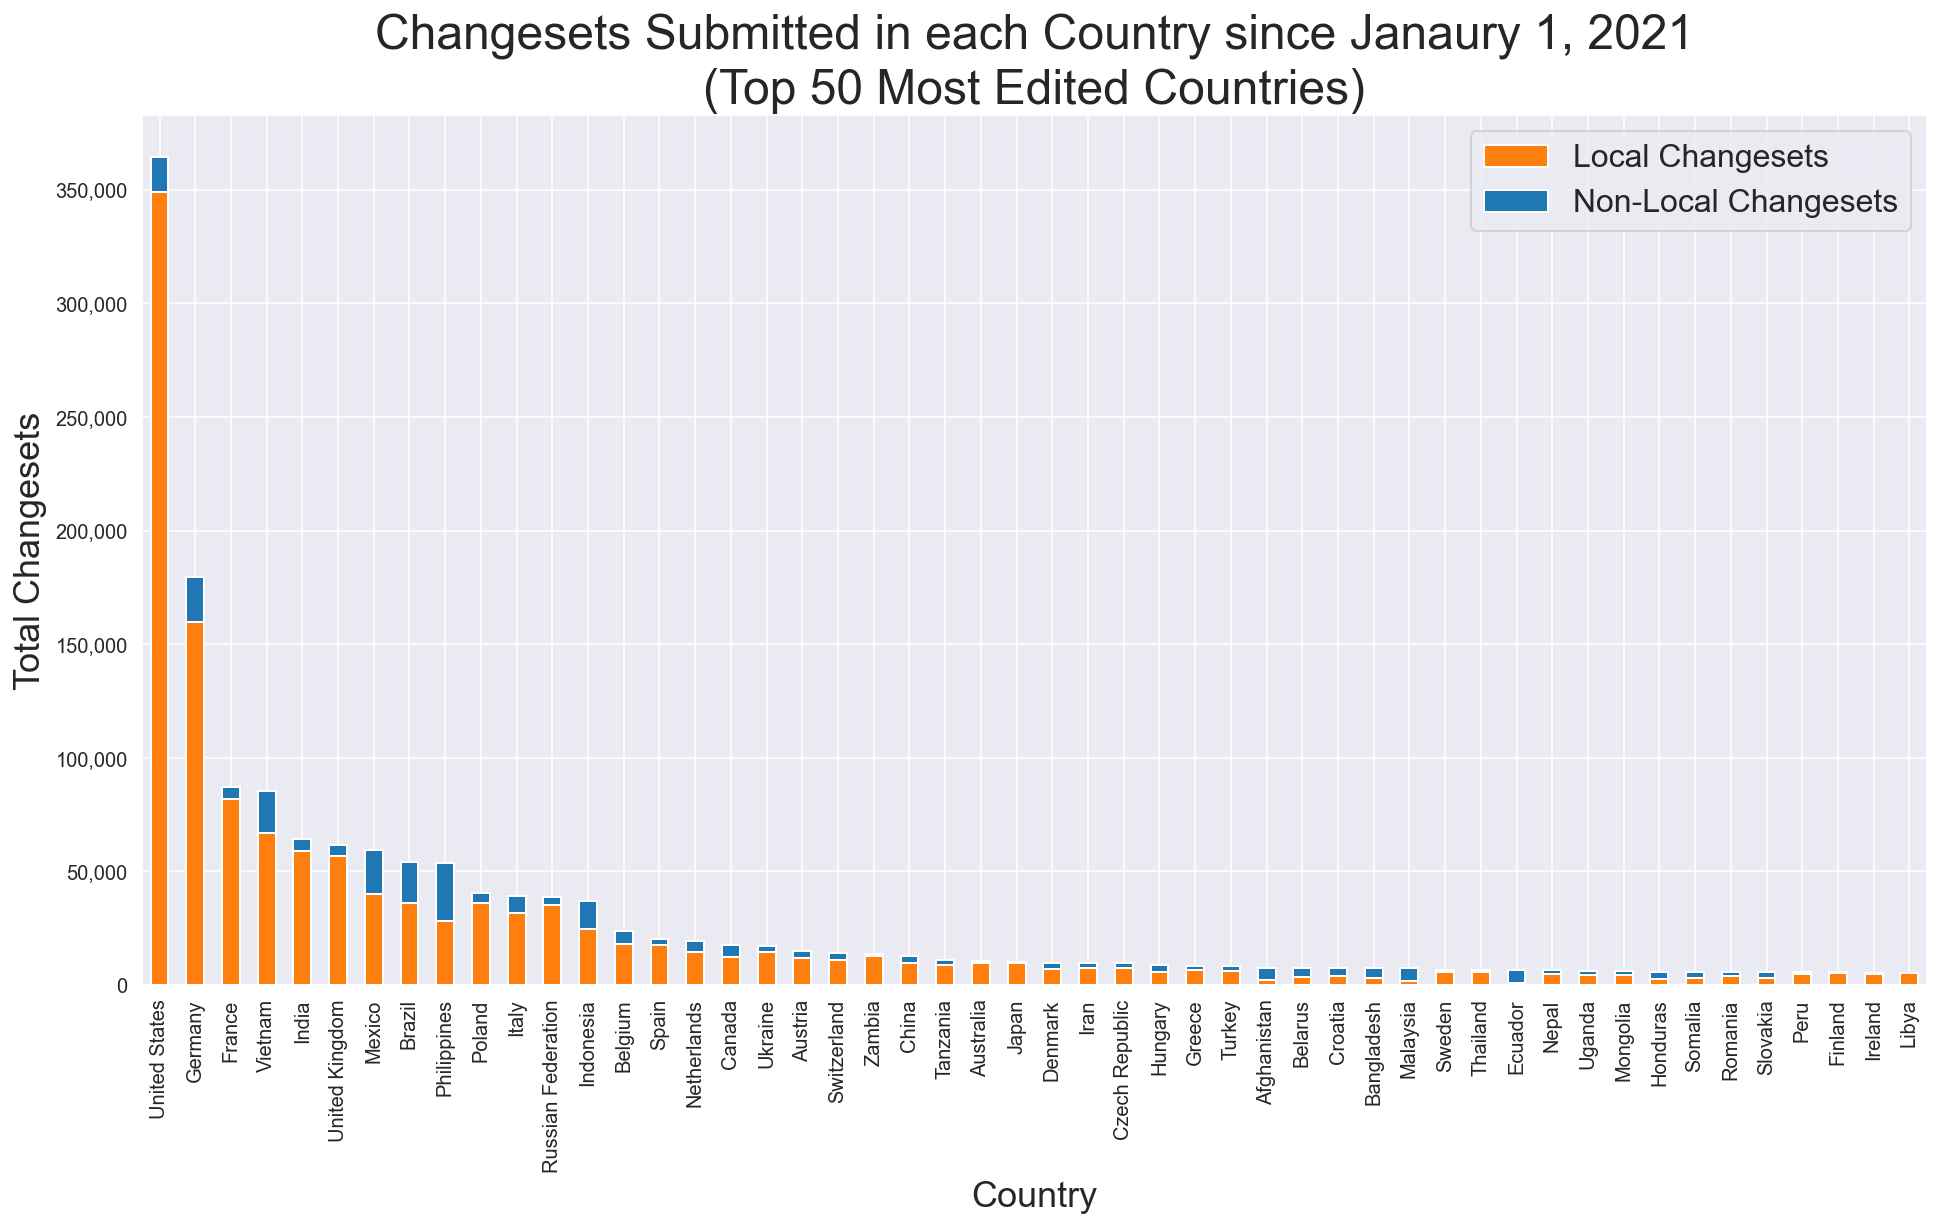

In [73]:
sns.set_style('darkgrid')
gb_country = df.groupby('country').aggregate({'uid':pd.Series.nunique,'user':'count','is_local':sum})
gb_country['non_local'] = gb_country.user - gb_country.is_local
gb_country = gb_country.rename(columns={'is_local':'Local Changesets','non_local':'Non-Local Changesets','uid':'Total Users','user':'Total Changesets'})
ax = gb_country.sort_values(by='Total Changesets', ascending=False).head(50)[
    ['Local Changesets','Non-Local Changesets']].plot.bar(stacked=True, 
    figsize=(16,8), color=list(reversed(sns.color_palette(as_cmap=True)[:2])))
ax.set_xlabel("Country", fontsize=18); ax.set_ylabel("Total Changesets", fontsize=18);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_title("Changesets Submitted in each Country since Janaury 1, 2021\n(Top 50 Most Edited Countries)", fontsize=24);
ax.legend(fontsize=16);

In [74]:
order = gb_country.sort_values(by='Total Changesets',ascending=False).index[:50]

# Aggregated by Mapper

Breaking down the "Total Mappers" count by local/non-local per Country

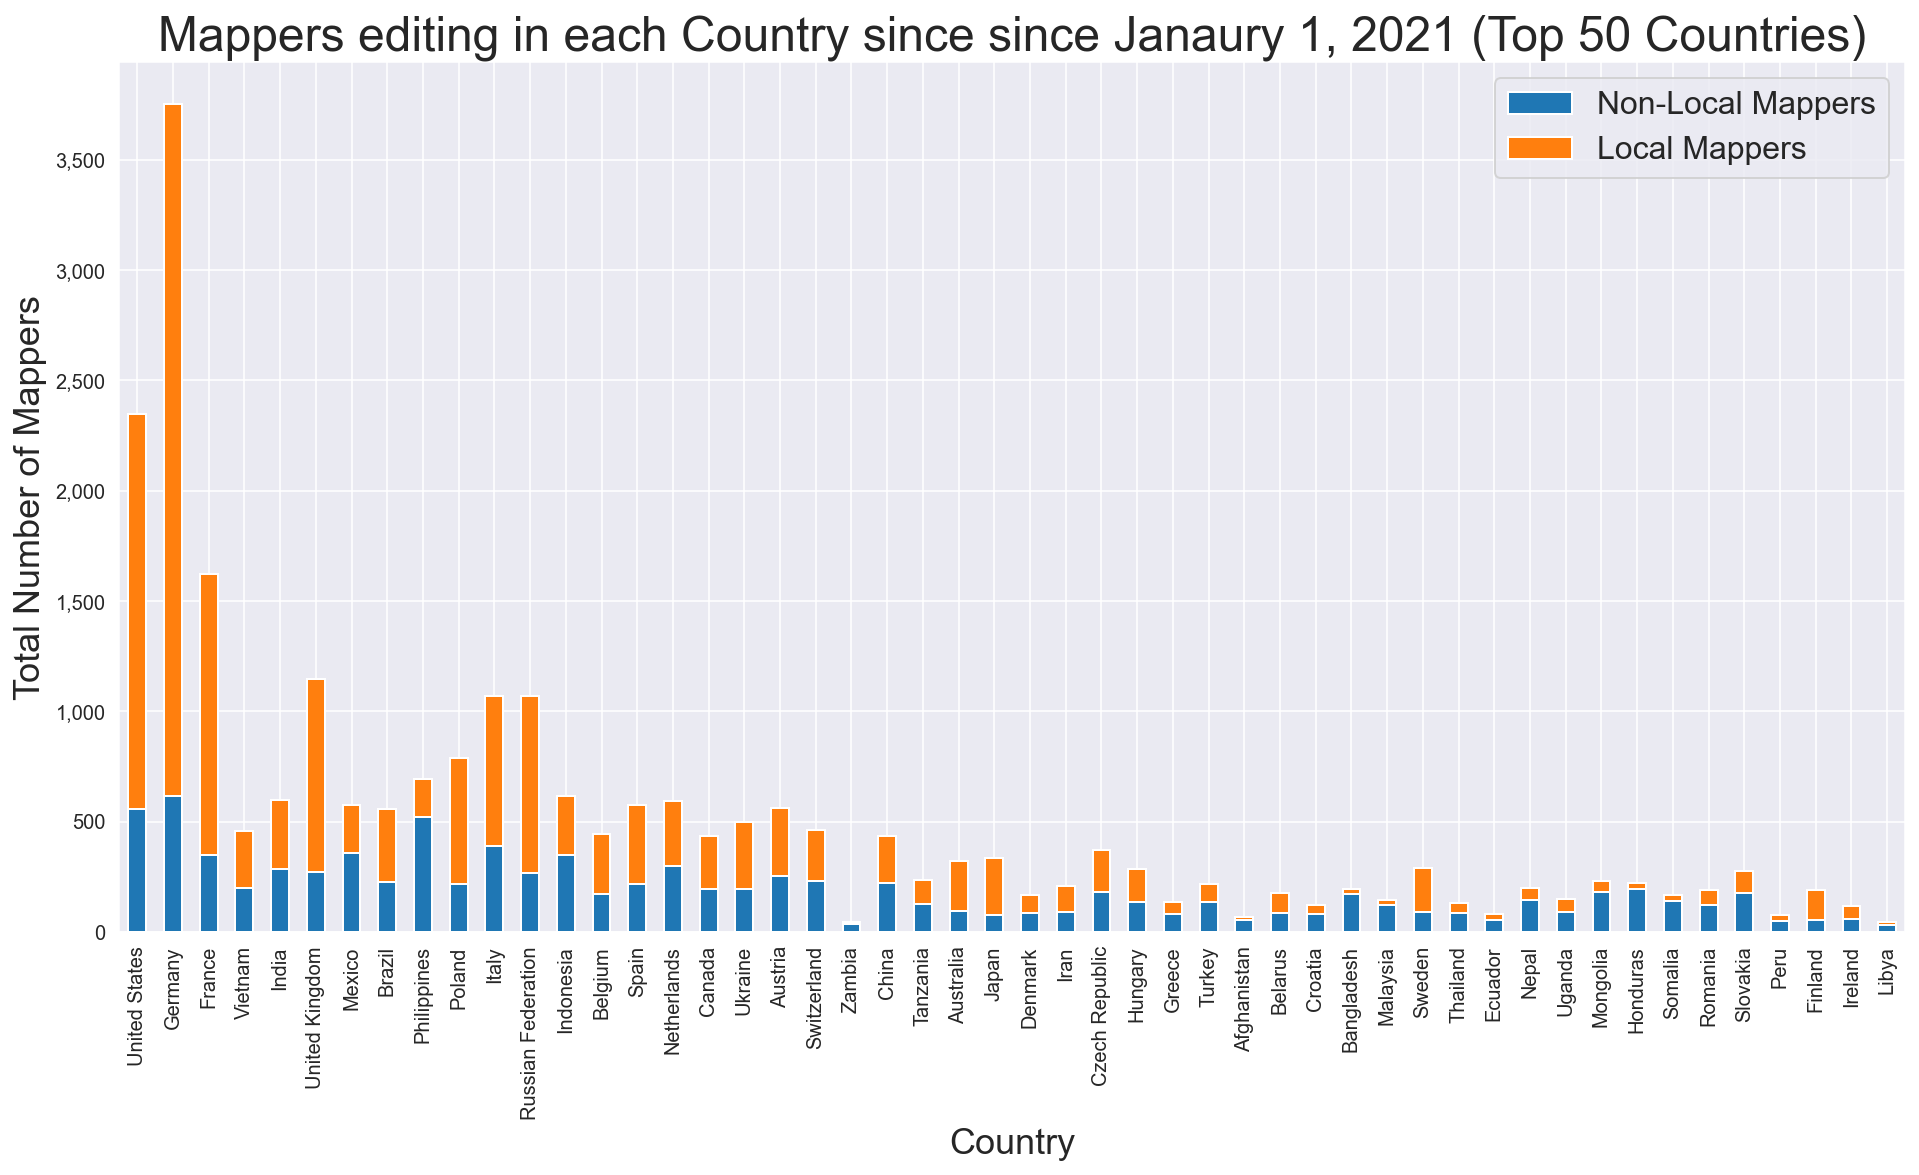

In [75]:
sns.set_style('darkgrid')
gb_country_local = df[df.editing_days_in_last365>7].groupby(['country','is_local']).aggregate({'uid':pd.Series.nunique}).unstack()
gb_country_local.columns = gb_country_local.columns.droplevel()
gb_country_local = gb_country_local.rename(columns={ False:"Non-Local Mappers",True:"Local Mappers"})
ax = gb_country_local.loc[order].plot.bar(stacked=True, figsize=(16,8))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_xlabel("Country", fontsize=18); ax.set_ylabel("Total Number of Mappers", fontsize=18);
ax.set_title("Mappers editing in each Country since since Janaury 1, 2021 (Top 50 Countries)", fontsize=24);
ax.legend(fontsize=16);

# Identifying the _Active Contributors_ active per Country?

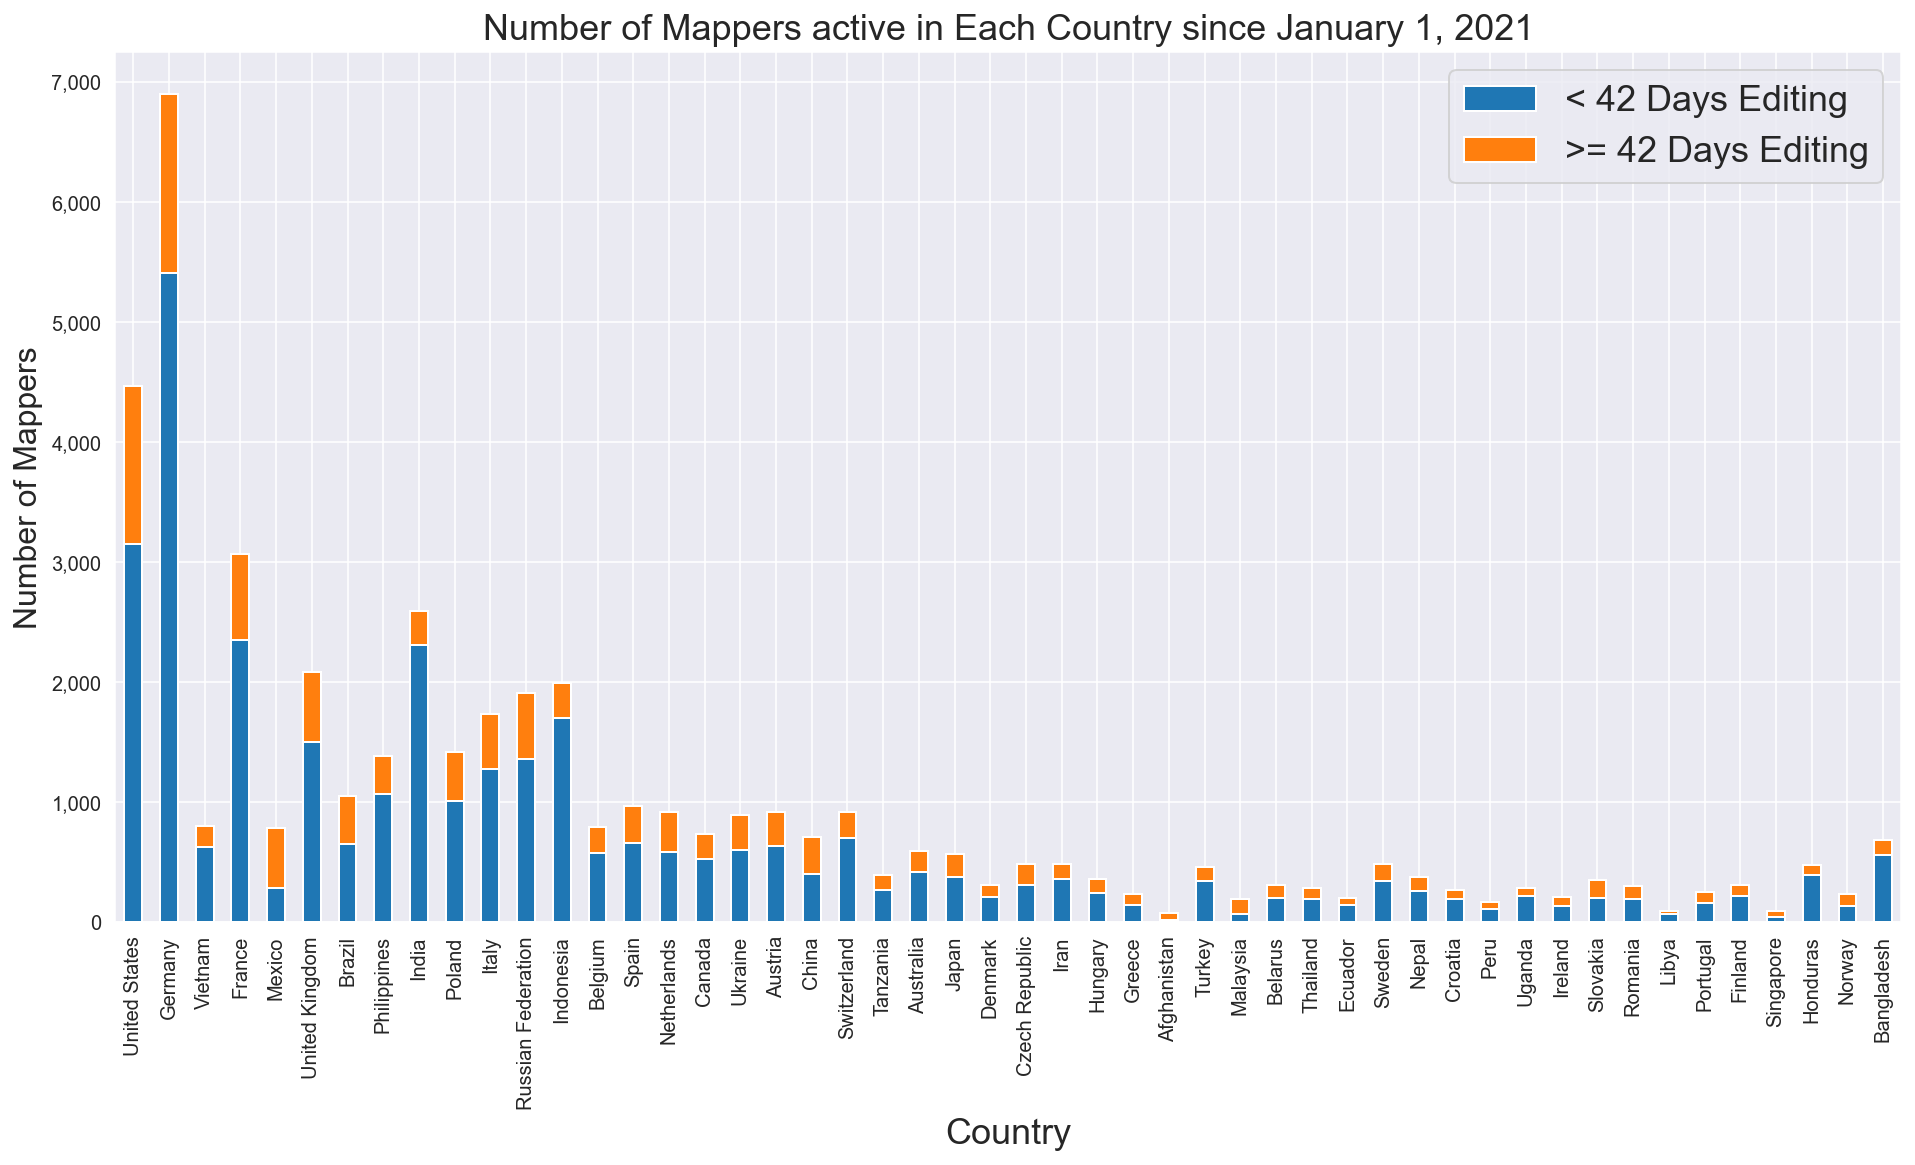

In [71]:
df['is_active_contributor'] = df.editing_days_in_last365 > 41
gb_country_active = df.groupby(['country','is_active_contributor']).aggregate({'uid':pd.Series.nunique}).unstack()
gb_country_active.columns = gb_country_active.columns.droplevel()
gb_country_active = gb_country_active.rename(columns={ False:"< 42 Days Editing",True:">= 42 Days Editing"})
# ax = gb_country_active.sort_values(by="< 42 Days Editing",ascending=False).head(50).plot.bar(stacked=True, figsize=(16,8));
ax = gb_country_active.loc[order].plot.bar(stacked=True, figsize=(16,8));
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=18)
ax.set_ylabel("Number of Mappers", fontsize=16); ax.set_xlabel("Country", fontsize=18);
ax.set_title("Number of Mappers active in Each Country since January 1, 2021", fontsize=18);

In [31]:
as_table = gb_country_local.join(gb_country).join(gb_country_active)
as_table

,Non-Local Mappers,Local Mappers,Total Users,Total Changesets,Local Changesets,Non-Local Changesets,< 42 Days Editing,>= 42 Days Editing
country,,,,,,,,
Afghanistan,63.0,20.0,77,7669,2277,5392,19.0,58.0
Albania,32.0,14.0,46,234,74,160,24.0,22.0
Algeria,41.0,61.0,102,2980,2800,180,73.0,29.0
American Samoa,4.0,NaN,4,16,0,16,NaN,4.0
Andorra,1.0,NaN,1,1,0,1,NaN,1.0
...,...,...,...,...,...,...,...,...
Vietnam,378.0,423.0,797,85497,66782,18715,625.0,172.0
Wallis and Futuna,1.0,NaN,1,1,0,1,1.0,NaN
Yemen,23.0,43.0,66,292,185,107,48.0,18.0


In [32]:
as_table.to_csv('./data/country_editing_stats_in_2020.csv')

In [ ]:
# But where are the active contributors from?

In [33]:
by_user = df.drop_duplicates(subset='user')

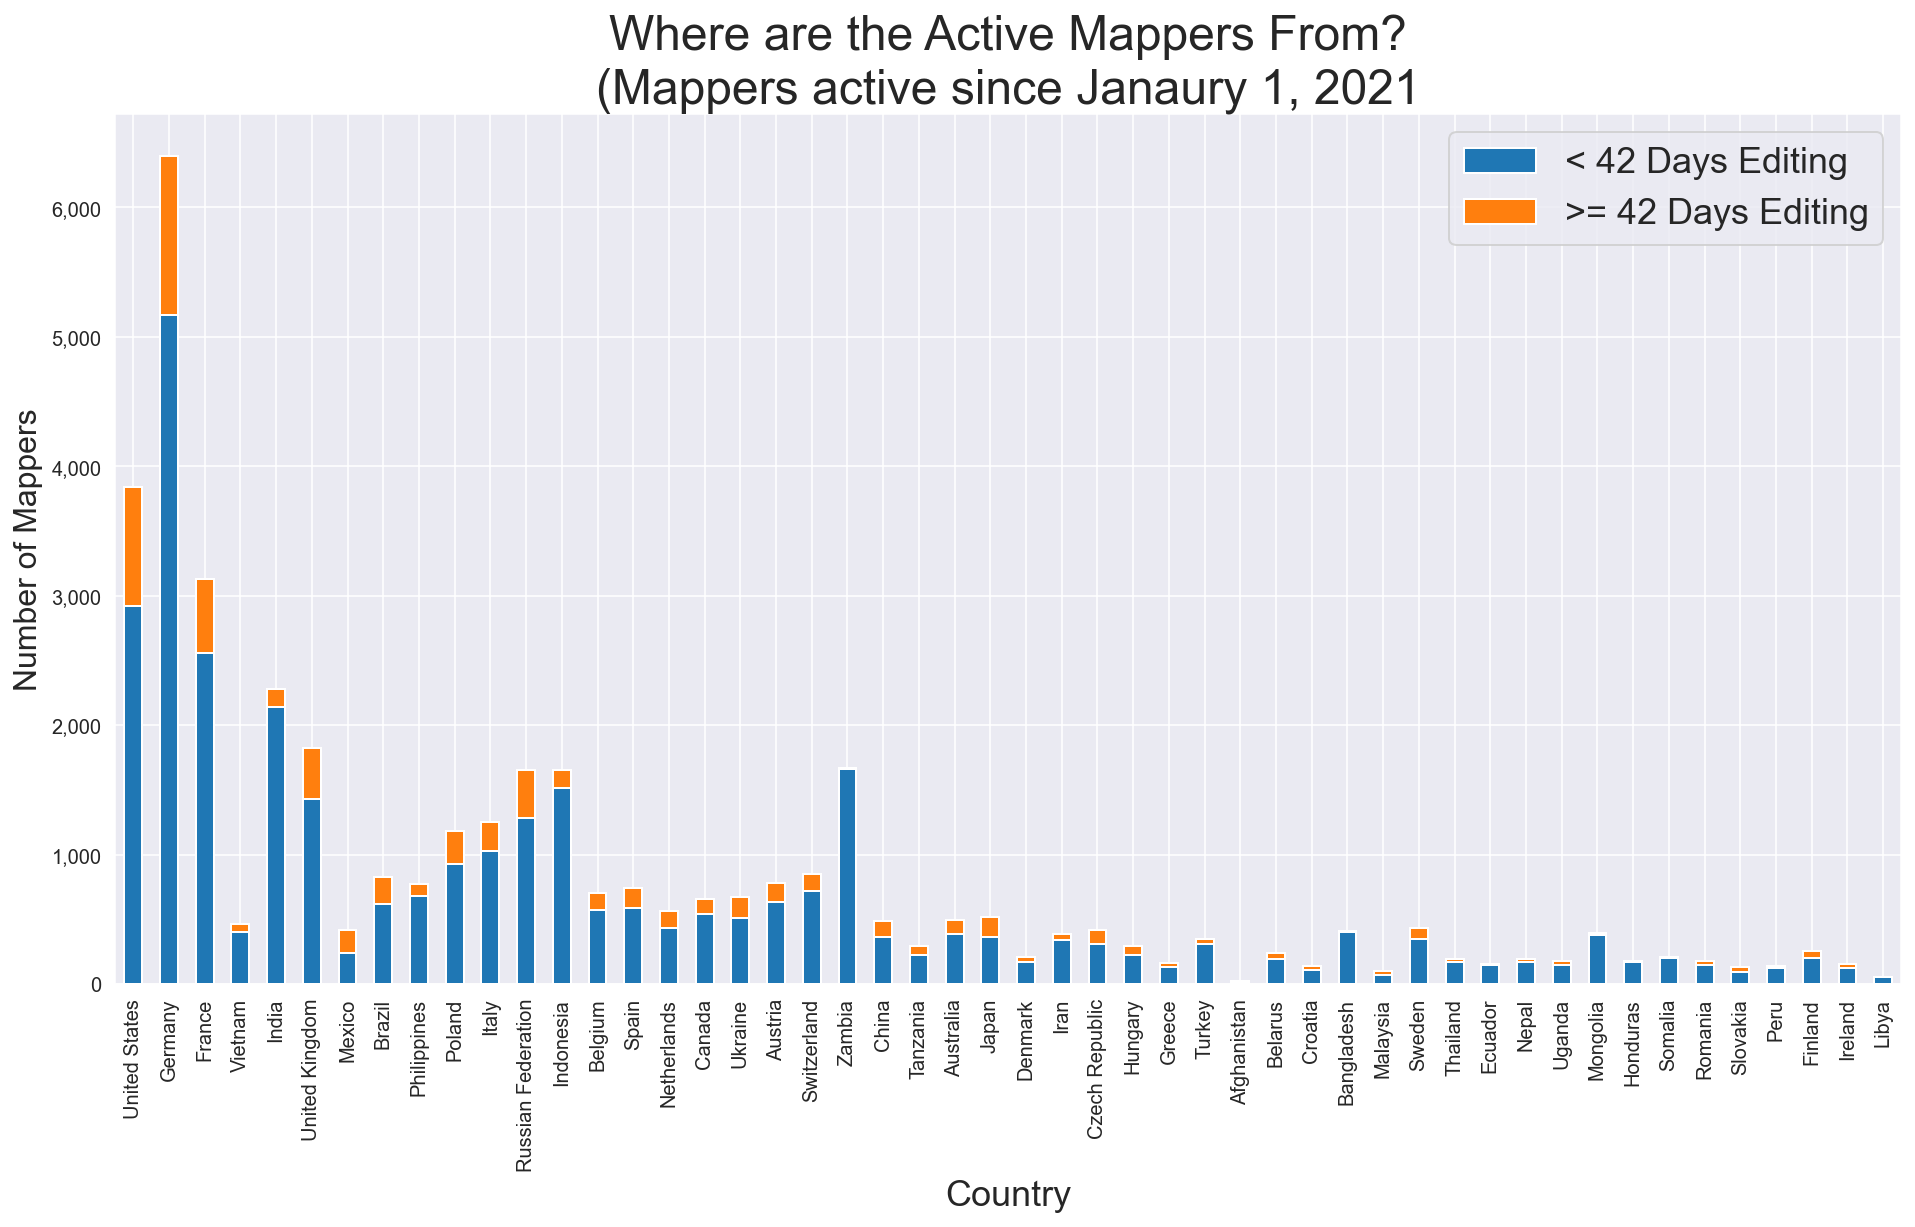

In [34]:
gb_home_country_active = by_user.groupby(['home_country','is_active_contributor']).aggregate({'uid':pd.Series.nunique}).unstack()
gb_home_country_active.columns = gb_home_country_active.columns.droplevel()
gb_home_country_active = gb_home_country_active.rename(columns={ False:"< 42 Days Editing",True:">= 42 Days Editing"})
# ax = gb_country_active.sort_values(by="< 42 Days Editing",ascending=False).head(50).plot.bar(stacked=True, figsize=(16,8));
ax = gb_home_country_active.loc[order].plot.bar(stacked=True, figsize=(16,8));
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=18)
ax.set_ylabel("Number of Mappers", fontsize=16); ax.set_xlabel("Country", fontsize=18);
ax.set_title("Where are the Active Mappers From?\n(Mappers active since Janaury 1, 2021", fontsize=24);

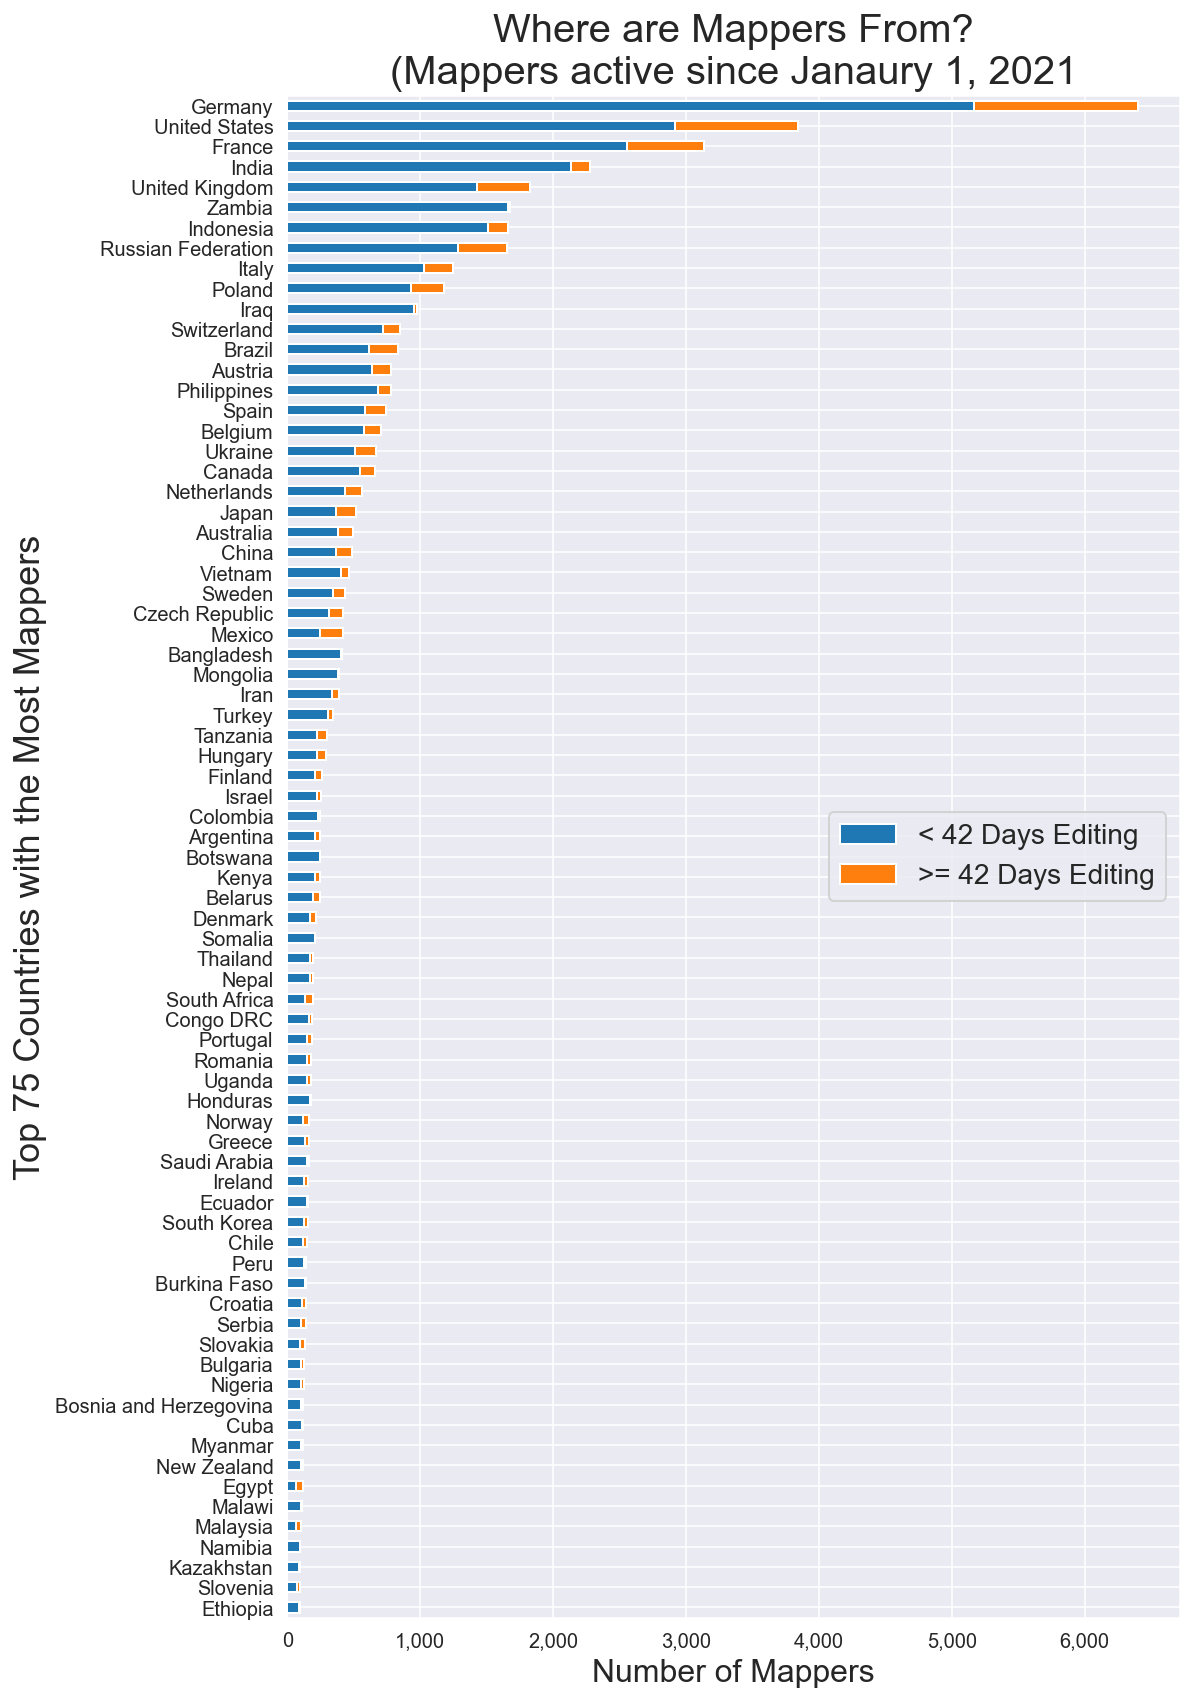

In [57]:
gb_home_country_active = by_user.groupby(['home_country','is_active_contributor']).aggregate({'uid':pd.Series.nunique}).unstack()
gb_home_country_active.columns = gb_home_country_active.columns.droplevel()
gb_home_country_active = gb_home_country_active.rename(columns={ False:"< 42 Days Editing",True:">= 42 Days Editing"})
gb_home_country_active['total'] = gb_home_country_active['< 42 Days Editing'] + gb_home_country_active['>= 42 Days Editing']
ax = gb_home_country_active.sort_values(by='total',ascending=False)[
    ['< 42 Days Editing','>= 42 Days Editing']].head(75).plot.barh(stacked=True, figsize=(8,14));
# ax = gb_home_country_active.loc[order].plot.bar(stacked=True, figsize=(16,8));
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=14, loc='center right')
ax.invert_yaxis()
ax.set_xlabel("Number of Mappers", fontsize=16); 
ax.set_ylabel("Top 75 Countries with the Most Mappers", fontsize=18);
ax.set_title("Where are Mappers From?\n(Mappers active since Janaury 1, 2021", fontsize=20);